# $Airbnb\ London\ Price\ Prediction$

# $General\ Overview$

### Introduction

This project aims to produce a model which will estimate the price of an Airbnb listing in London.<br> 
We will use the following regression models:

1. Linear Regression

2. Decision-Tree

3. KNN

### Dataset

* Data was taken from Kaggle - https://www.kaggle.com/jinxzed/londonairbnb
* This dataset provides information about London's Aitbnb listings features associated with the price of accomodation.

### Project Modules & Packages

In [ ]:
!pip install dtreeviz &> /dev/null

In [ ]:
# General tools
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import pairwise_distances


# For the tree visualization
# import pydot
# from IPython.display import Image
# from sklearn.externals.six import StringIO
from dtreeviz.trees import dtreeviz

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from scipy.stats import jarque_bera, shapiro, bartlett
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

Mounted at /content/drive


# $Features\ Exploration\ \&\ Data\ Wrangling$

### Load CSV file to Pandas DataFrame

In [ ]:
londonAirbnb = pd.read_csv("/content/drive/MyDrive/LondonAirBNB.csv")

In [ ]:
londonAirbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83689 entries, 0 to 83688
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           83689 non-null  int64  
 1   experiences_offered          83689 non-null  object 
 2   host_response_time           83689 non-null  object 
 3   host_acceptance_rate         60531 non-null  float64
 4   host_is_superhost            83689 non-null  int64  
 5   host_has_profile_pic         83689 non-null  int64  
 6   host_identity_verified       83689 non-null  int64  
 7   neighbourhood_cleansed       83689 non-null  int64  
 8   country                      83689 non-null  object 
 9   is_location_exact            83689 non-null  int64  
 10  property_type                83689 non-null  object 
 11  room_type                    83689 non-null  object 
 12  accommodates                 83689 non-null  int64  
 13  bathrooms       

In [ ]:
londonAirbnb.shape

(83689, 49)

In [ ]:
londonAirbnb.head()

,id,experiences_offered,host_response_time,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,country,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month,week_book,month_book,security,amenity_sum,distance,premium,lastreviewdays,firstreviewdays
0,11551,family,within an hour,100.0,0,1,1,20,United Kingdom,1,Apartment,Entire home/apt,4,1.0,1.0,3.0,Real Bed,88.0,400.0,35.0,2,20.0,1,12,42,72,347,192,9,91.0,9.0,9.0,10.0,10.0,9.0,9.0,0,1,0,strict,1.54,1,1,1,29,5.350324,0.0,82,3740
1,13913,business,unknown,89.0,0,1,1,23,United Kingdom,1,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,65.0,100.0,15.0,1,15.0,1,12,42,72,347,21,5,97.0,10.0,10.0,10.0,10.0,9.0,9.0,0,0,0,moderate,0.18,1,1,1,44,6.579790,0.0,115,3590
2,15400,romantic,within a day,83.0,0,1,1,31,United Kingdom,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,100.0,150.0,50.0,2,0.0,1,0,0,13,288,89,4,96.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1,0,strict,0.70,1,1,1,30,3.729734,0.0,92,3830
3,17402,none,within an hour,96.0,0,1,1,32,United Kingdom,0,Apartment,Entire home/apt,6,2.0,3.0,3.0,Real Bed,300.0,350.0,90.0,3,10.0,1,9,39,69,326,42,2,94.0,10.0,9.0,9.0,9.0,10.0,9.0,0,1,0,strict,0.37,1,1,1,30,1.607089,0.0,224,3372
4,17506,business,other,NaN,0,1,0,28,United Kingdom,1,Bed and breakfast,Private room,2,1.0,1.0,1.0,Real Bed,150.0,0.0,0.0,1,0.0,1,11,41,71,346,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,strict,0.00,1,1,1,18,5.879095,0.0,-6,-6


In [ ]:
londonAirbnb = londonAirbnb.drop( ["country","lastreviewdays", "firstreviewdays"],axis=1)

### Find missing values

In [ ]:
def missing(data):
    if data.isna().sum().sum()==0:
        return "all missing values treated"
    data = data.isna().sum()/data.shape[0]
    data[data>0].plot(kind='bar', figsize=(16,7))
    all_miss = list(data[data==1].index)
    print("These columns have all the values missing",all_miss)
    plt.title("Missing value plot")
    plt.tight_layout()
    plt.xlabel("Column")
    plt.ylabel("Missing data in %")
    plt.xticks(rotation=90)
    plt.show()

These columns have all the values missing []


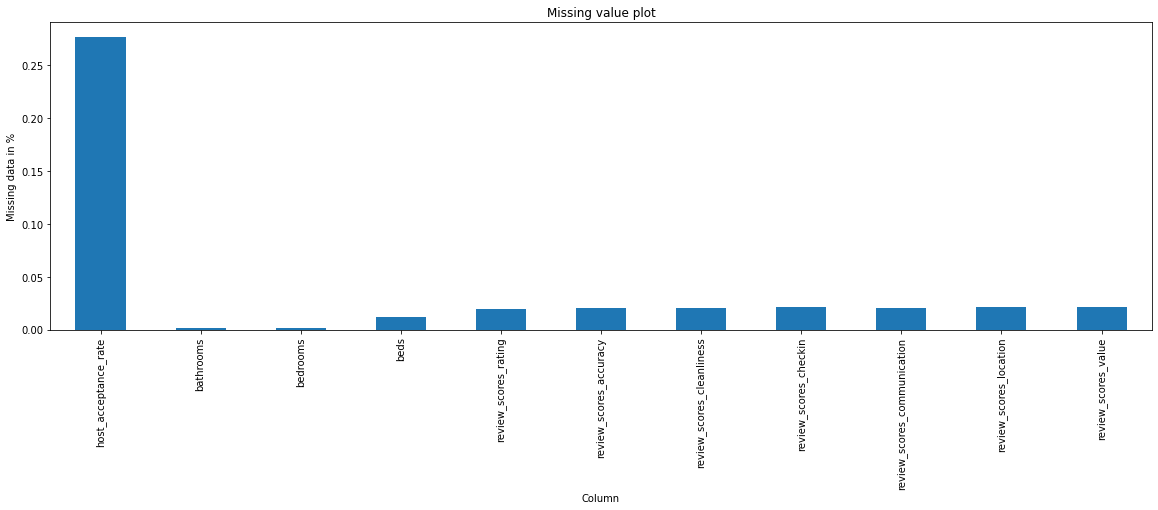

In [ ]:
missing(londonAirbnb)

In [ ]:
londonAirbnb.dropna(subset=['host_acceptance_rate','bathrooms','bedrooms','beds'],inplace=True)
londonAirbnb.dropna(subset=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'],inplace=True)
londonAirbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58980 entries, 0 to 83688
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           58980 non-null  int64  
 1   experiences_offered          58980 non-null  object 
 2   host_response_time           58980 non-null  object 
 3   host_acceptance_rate         58980 non-null  float64
 4   host_is_superhost            58980 non-null  int64  
 5   host_has_profile_pic         58980 non-null  int64  
 6   host_identity_verified       58980 non-null  int64  
 7   neighbourhood_cleansed       58980 non-null  int64  
 8   is_location_exact            58980 non-null  int64  
 9   property_type                58980 non-null  object 
 10  room_type                    58980 non-null  object 
 11  accommodates                 58980 non-null  int64  
 12  bathrooms                    58980 non-null  float64
 13  bedrooms        

### Drop non-contributing Columns/Features

Removing low variance features:<br>
Combine all reviews columns to a single average column as all reflect similar behaviour:

In [ ]:
# average of the review and removing 0 reviews
londonAirbnb['reviews_average'] = (londonAirbnb.review_scores_rating + londonAirbnb.review_scores_accuracy + londonAirbnb.review_scores_cleanliness + londonAirbnb.review_scores_checkin + londonAirbnb.review_scores_communication + londonAirbnb.review_scores_location + londonAirbnb.review_scores_value ) / 7
londonAirbnb['reviews_average'].value_counts()
londonAirbnb = londonAirbnb[londonAirbnb['reviews_average']> 0]
londonAirbnb['reviews_average'].shape

(48361,)

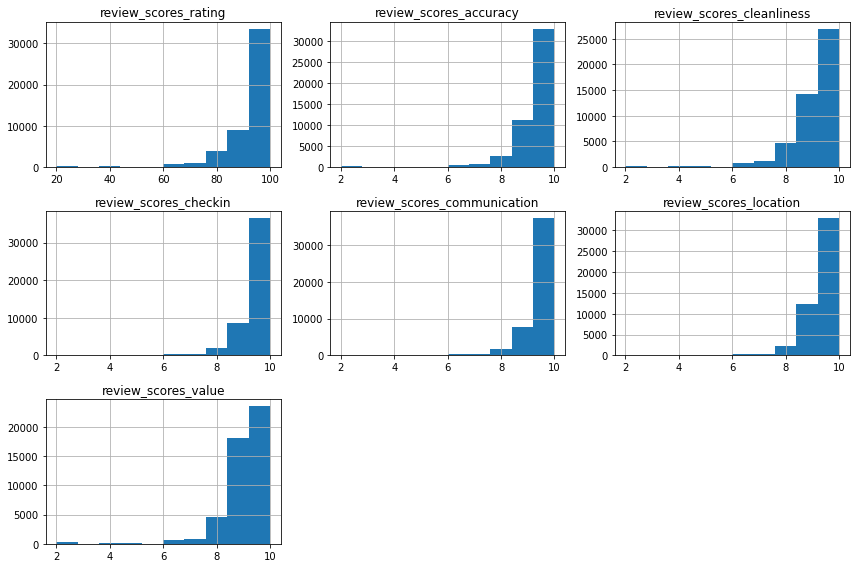

In [ ]:
vars = list(londonAirbnb.columns[londonAirbnb.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(vars):
    ax = fig.add_subplot(3,3,i+1)
    londonAirbnb[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [ ]:
londonAirbnb.drop( ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value'],
                  axis=1,inplace=True)

Drop more non-contributing columns:

In [ ]:
londonAirbnb.drop( ['week_book','month_book','security_deposit','extra_people',
                    'availability_30','availability_60','availability_90'],
                   axis=1, inplace=True)
londonAirbnb.drop(columns='experiences_offered', axis = 1, inplace = True)
londonAirbnb.drop(columns='host_response_time', axis = 1, inplace = True)

Combine price column with cleaning_fee column to a single total_price column:

In [ ]:
londonAirbnb['total_price'] = londonAirbnb.price + londonAirbnb.cleaning_fee
londonAirbnb = londonAirbnb.drop( ["price","cleaning_fee"],axis=1)

In [ ]:
londonAirbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48361 entries, 0 to 83290
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        48361 non-null  int64  
 1   host_acceptance_rate      48361 non-null  float64
 2   host_is_superhost         48361 non-null  int64  
 3   host_has_profile_pic      48361 non-null  int64  
 4   host_identity_verified    48361 non-null  int64  
 5   neighbourhood_cleansed    48361 non-null  int64  
 6   is_location_exact         48361 non-null  int64  
 7   property_type             48361 non-null  object 
 8   room_type                 48361 non-null  object 
 9   accommodates              48361 non-null  int64  
 10  bathrooms                 48361 non-null  float64
 11  bedrooms                  48361 non-null  float64
 12  beds                      48361 non-null  float64
 13  bed_type                  48361 non-null  object 
 14  guests

Transform host_acceptance_rate into a categorical feature, rather than a numerical one.
*   0-49%
*   50-89%
*   90-99%
*   100%

100.0    0.324580
99.0     0.062674
98.0     0.047745
97.0     0.035483
96.0     0.033147
           ...   
5.0      0.000165
26.0     0.000145
6.0      0.000103
12.0     0.000103
4.0      0.000083
Name: host_acceptance_rate, Length: 98, dtype: float64
83.59260561196005
96.0


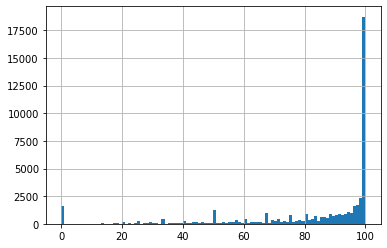

In [ ]:
print(londonAirbnb["host_acceptance_rate"].value_counts(normalize=True))
print(londonAirbnb['host_acceptance_rate'].mean())
print(londonAirbnb['host_acceptance_rate'].median())
londonAirbnb["host_acceptance_rate"].hist(bins=100)

In [ ]:
# def group_host_acceptance_rate(data):
#   acceptance_rate_by_group = 0         

#   if data['host_acceptance_rate'] < 49 :
#         distance_by_group = 1
#   elif data['host_acceptance_rate'] >= 50 and  data['distance'] < 90:
#         distance_by_group = 2
#   elif data['host_acceptance_rate'] >= 90 and  data['distance'] < 100:
#         distance_by_group = 3
#   elif data['host_acceptance_rate'] == 100:
#         distance_by_group = 4

#   return pd.Series([acceptance_rate_by_group])

In [ ]:
# londonAirbnb['host_acceptance_rate_group'] = londonAirbnb.apply(group_host_acceptance_rate, axis=1)
# londonAirbnb.drop(columns='host_acceptance_rate', axis=1, inplace=True)

Combine 'Hotel1' and 'Hotel2' property types to a single 'Hotel' type column:

In [ ]:
londonAirbnb.property_type.replace(['Hotel1','Hotel2'],'Hotel',inplace = True)

Get One-hot encoding for categorical columns:  

In [ ]:
# new ver
# def get_dummies(df,col):
#   type_dummies = pd.get_dummies(df, columns=[col])  
#   df = pd.merge(df, type_dummies)
#   df.drop(columns= col, axis=1, inplace =True)
#   return df

In [ ]:
# londonAirbnb = get_dummies(londonAirbnb, 'room_type')
# londonAirbnb = get_dummies(londonAirbnb, 'bed_type')
# londonAirbnb = get_dummies(londonAirbnb, 'cancellation_policy')
# londonAirbnb = get_dummies(londonAirbnb, 'property_type')

# $EDA$

### Dataset Info

In [ ]:
londonAirbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48361 entries, 0 to 83290
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        48361 non-null  int64  
 1   host_acceptance_rate      48361 non-null  float64
 2   host_is_superhost         48361 non-null  int64  
 3   host_has_profile_pic      48361 non-null  int64  
 4   host_identity_verified    48361 non-null  int64  
 5   neighbourhood_cleansed    48361 non-null  int64  
 6   is_location_exact         48361 non-null  int64  
 7   property_type             48361 non-null  object 
 8   room_type                 48361 non-null  object 
 9   accommodates              48361 non-null  int64  
 10  bathrooms                 48361 non-null  float64
 11  bedrooms                  48361 non-null  float64
 12  beds                      48361 non-null  float64
 13  bed_type                  48361 non-null  object 
 14  guests

In [ ]:
londonAirbnb.describe(include = 'all')

,id,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,has_availability,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month,security,amenity_sum,distance,premium,reviews_average,total_price
count,4.836100e+04,48361.000000,48361.000000,48361.000000,48361.000000,48361.000000,48361.000000,48361,48361,48361.000000,48361.000000,48361.000000,48361.00000,48361,48361.000000,48361.0,48361.000000,48361.000000,48361.000000,48361.0,48361.000000,48361.0,48361,48361.000000,48361.0,48361.000000,48361.000000,48361.000000,48361.000000,48361.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,4,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apartment,Entire home/apt,NaN,NaN,NaN,NaN,Real Bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,strict,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34755,28490,NaN,NaN,NaN,NaN,48046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.510067e+07,83.592606,0.239966,0.997353,0.358223,22.131842,0.699758,NaN,NaN,3.302847,1.315957,1.411799,1.79043,NaN,1.733173,1.0,139.657265,26.873348,8.145055,0.0,0.438308,0.0,NaN,0.956595,1.0,23.363102,6.916719,0.112942,21.362556,157.176878
std,1.202301e+07,24.561925,0.427067,0.051379,0.479483,7.953020,0.458368,NaN,NaN,2.052317,0.623278,0.911919,1.31944,NaN,1.451468,0.0,135.479750,44.581939,11.443176,0.0,0.496185,0.0,NaN,1.068599,0.0,9.028935,4.461411,0.367100,2.029292,247.133554
min,1.155100e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.00000,NaN,1.000000,1.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,NaN,0.010000,1.0,1.000000,0.032861,0.000000,4.571429,1.000000
25%,1.637908e+07,78.000000,0.000000,1.000000,0.000000,18.000000,0.000000,NaN,NaN,2.000000,1.000000,1.000000,1.00000,NaN,1.000000,1.0,0.000000,4.000000,1.000000,0.0,0.000000,0.0,NaN,0.270000,1.0,17.000000,3.912533,0.000000,20.857143,60.000000
50%,2.665226e+07,96.000000,0.000000,1.000000,0.000000,23.000000,1.000000,NaN,NaN,2.000000,1.000000,1.000000,1.00000,NaN,1.000000,1.0,78.000000,11.000000,4.000000,0.0,0.000000,0.0,NaN,0.610000,1.0,23.000000,5.785137,0.000000,22.000000,116.000000
75%,3.570846e+07,100.000000,0.000000,1.000000,1.000000,29.000000,1.000000,NaN,NaN,4.000000,1.500000,2.000000,2.00000,NaN,2.000000,1.0,292.000000,30.000000,10.000000,0.0,1.000000,0.0,NaN,1.240000,1.0,29.000000,9.061384,0.000000,22.571429,190.000000


### Visualize Data (Incl. Outliers)

Correlations in dataframe:

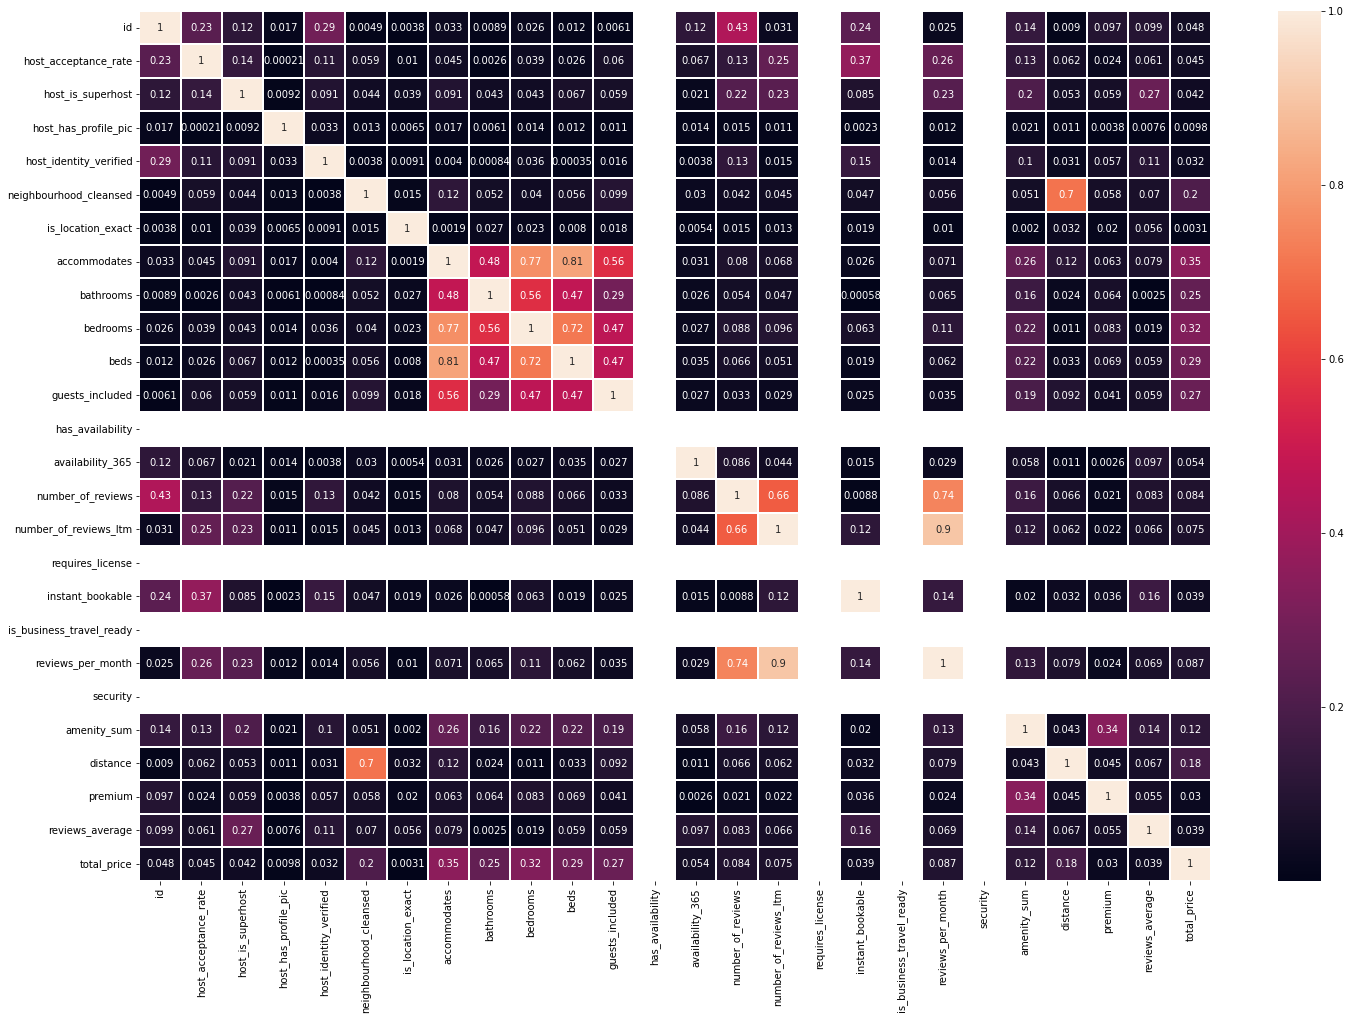

In [ ]:
plt.figure(figsize=(24,16))
sns.heatmap(londonAirbnb.corr().abs(), annot=True, linewidths=1)
plt.show()

Listings price distribution up to £2000 (majority of values):

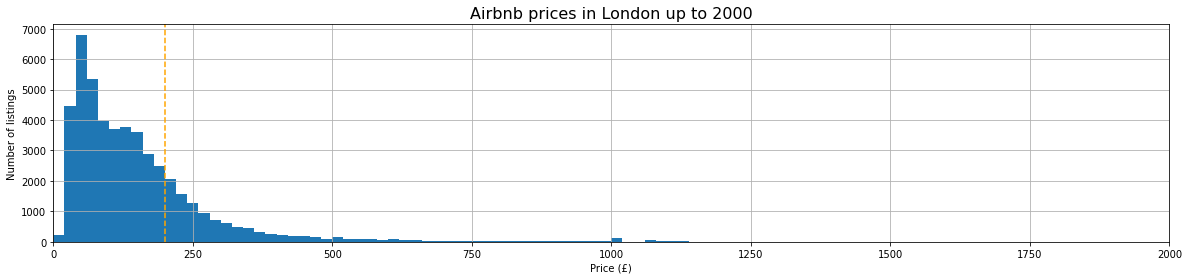

In [ ]:
# Distribution of listings prices from 0 to 1000
plt.figure(figsize=(20,4))
londonAirbnb.total_price.hist(bins=100, range=(0, 2000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb prices in London up to 2000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [ ]:
londonAirbnb2 = londonAirbnb[londonAirbnb['total_price'] <= 10000]

As further the distance from the center of London so does the listings' price is decreasing:

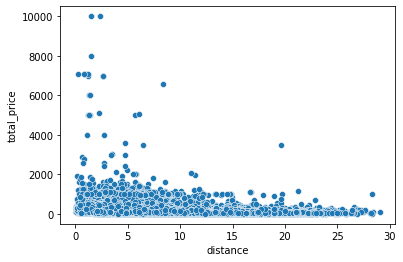

In [ ]:
sns.scatterplot(data=londonAirbnb2, x='distance', y='total_price')

In [ ]:
# sns.scatterplot(data=londonAirbnb2, x='distance_by_group', y='total_price')

Correlation of numeric values in dataframe:

In [ ]:
numeric = ["host_acceptance_rate","accommodates","bathrooms","bedrooms","beds",
           "guests_included","availability_365", "number_of_reviews",
           "number_of_reviews_ltm",'reviews_average',"reviews_per_month","amenity_sum","distance",
           "premium",'neighbourhood_cleansed','total_price']

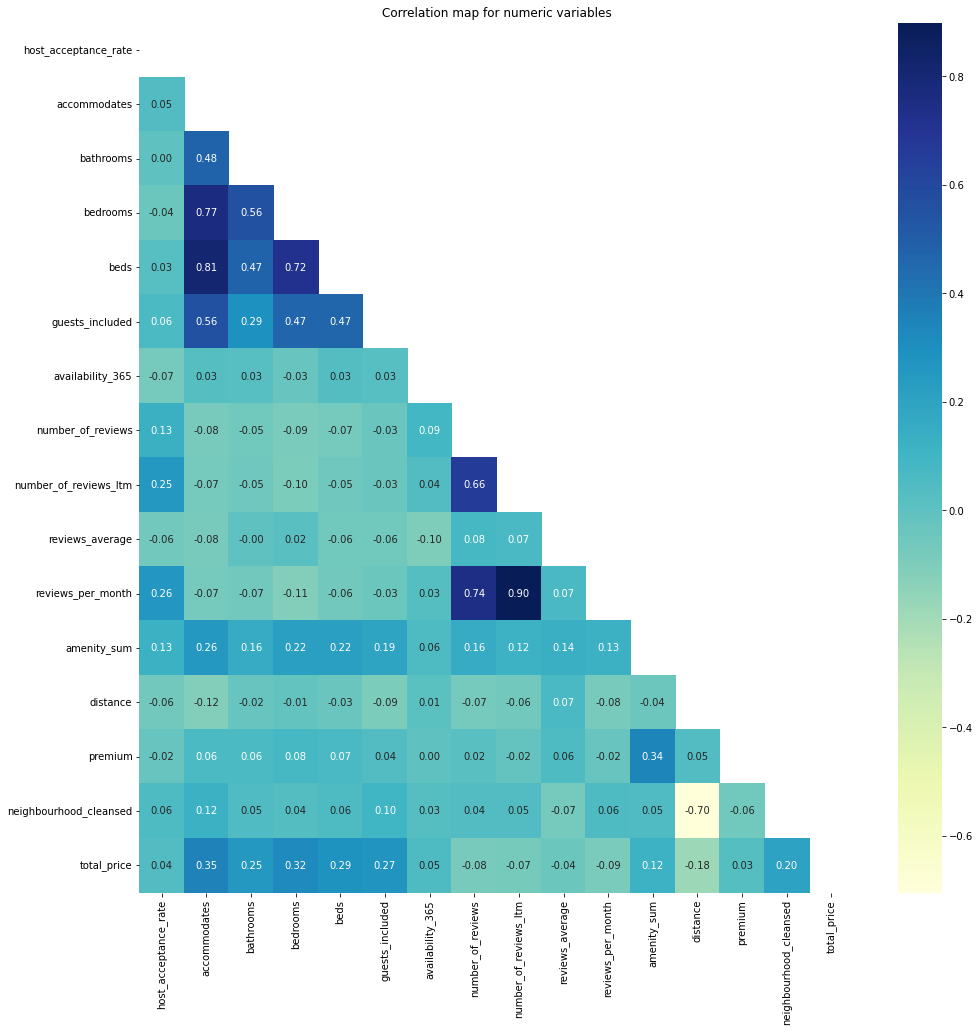

In [ ]:
plt.figure(figsize=(16,16))
corr = londonAirbnb[numeric].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, fmt='.2f', cmap='YlGnBu', mask=mask)
plt.title("Correlation map for numeric variables")
plt.show()

Transform continuous distance values to discrete groups:

In [ ]:
def get_dist_group(data):
  distance_by_group = 0         

  if data['distance'] < 2.5 :
        distance_by_group = 1
  elif data['distance'] >= 2.5 and  data['distance'] < 5:
        distance_by_group = 2
  elif data['distance'] >= 5 and  data['distance'] < 7.5:
        distance_by_group = 3
  elif data['distance'] >= 7.5 and  data['distance'] < 10:
        distance_by_group = 4
  elif data['distance'] >= 10 and  data['distance'] < 12.5:
        distance_by_group = 5
  elif data['distance'] >= 12.5 and  data['distance'] < 15:
        distance_by_group = 6
  elif data['distance'] >= 15 and  data['distance'] < 17.5:
        distance_by_group = 7
  elif data['distance'] >= 17.5 and  data['distance'] < 20:
        distance_by_group = 8
  elif data['distance'] >= 20 and  data['distance'] < 22.5:
        distance_by_group = 9
  elif data['distance'] >= 22.5 and  data['distance'] < 25:
        distance_by_group = 10
  elif data['distance'] >= 25 and  data['distance'] < 27.5:
        distance_by_group = 11
  elif data['distance'] >= 27.5 and  data['distance'] <= 30:
        distance_by_group = 12

  return pd.Series([distance_by_group])

In [ ]:
londonAirbnb['distance_by_group'] = londonAirbnb.apply(get_dist_group, axis=1)

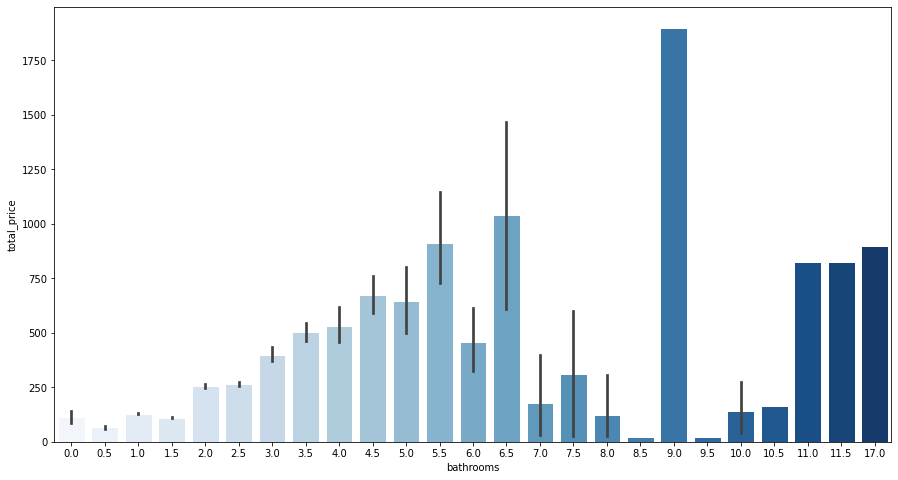

In [ ]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'bathrooms', y = 'total_price', data = londonAirbnb,
            palette = 'Blues', edgecolor = 'w')
plt.show()

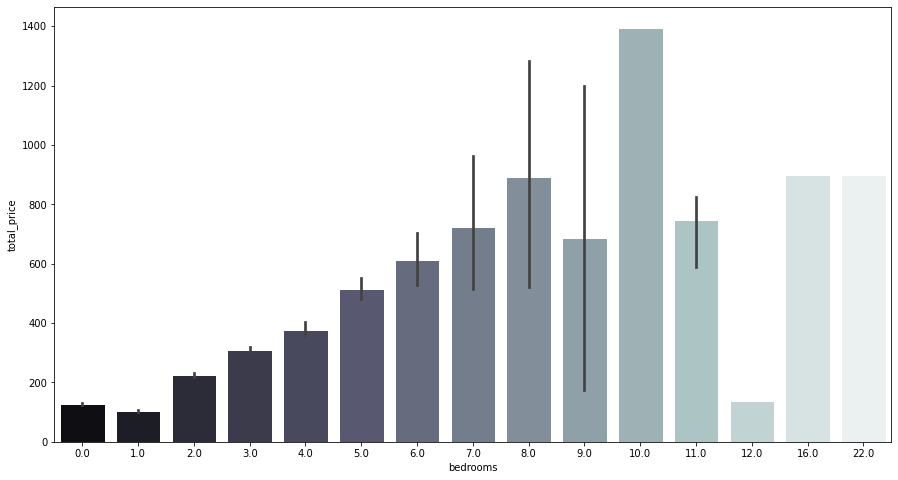

In [ ]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'bedrooms', y = 'total_price', data = londonAirbnb,
            palette = 'bone', edgecolor = 'w')
plt.show()

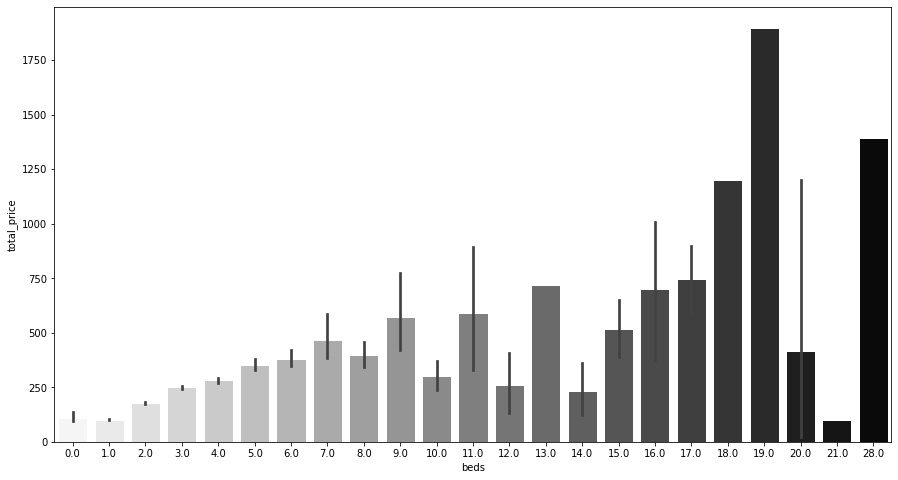

In [ ]:
plt.figure(figsize = (15,8))
sns.barplot(x = 'beds', y = 'total_price', data = londonAirbnb,
            palette = 'binary', edgecolor = 'w')
plt.show()

In [ ]:
londonAirbnb.drop(["id", "property_type", "room_type","bed_type",'cancellation_policy','requires_license'], axis=1, inplace=True)
londonAirbnb.drop(['host_identity_verified','premium','distance','security'], axis=1, inplace=True)
londonAirbnb.drop(['amenity_sum','is_business_travel_ready','has_availability','instant_bookable','number_of_reviews_ltm','is_location_exact'], axis=1, inplace=True)

## Remove outlires

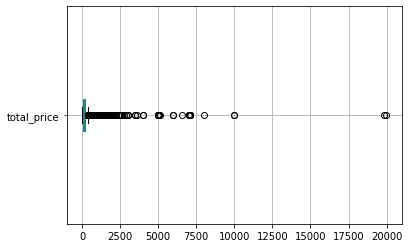

In [ ]:
# over price
londonAirbnb.boxplot(column='total_price', vert=False )

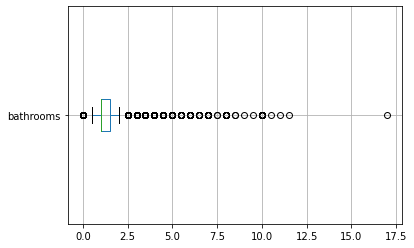

In [ ]:
londonAirbnb.boxplot(column='bathrooms', vert=False )


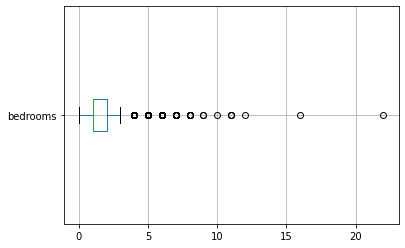

In [ ]:
londonAirbnb.boxplot(column='bedrooms', vert=False )

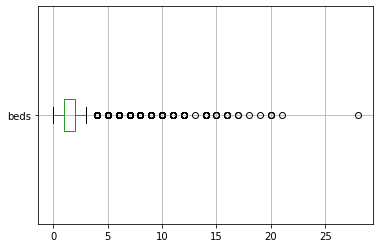

In [ ]:
londonAirbnb.boxplot(column='beds', vert=False )

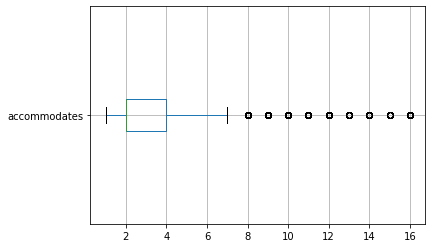

In [ ]:
londonAirbnb.boxplot(column='accommodates', vert=False , )

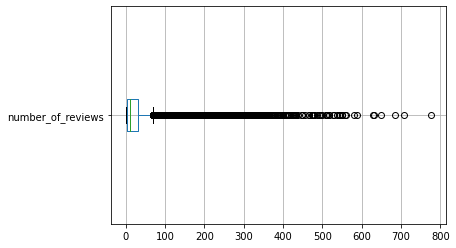

In [ ]:
londonAirbnb.boxplot(column='number_of_reviews', vert=False )

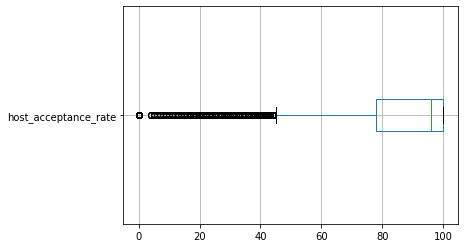

In [ ]:
londonAirbnb.boxplot(column='host_acceptance_rate', vert=False )

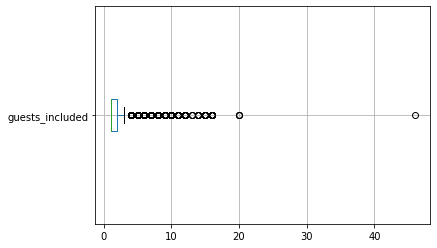

In [ ]:
londonAirbnb.boxplot(column='guests_included', vert=False )

In [ ]:
# Max CAP to numric Values
londonAirbnb_reduced  = londonAirbnb.copy()
MAX_PRICE = 900 
MAX_BATHROOMS = 8
MAX_BEDROOMS = 6
MAX_BEDS = 8
MAX_ACCOMMODATES = 10
MAX_NUMBER_OF_REVIEWS =  150
MAX_GUESTS_INCLUDED = 8

outliers = {'total_price':MAX_PRICE, 'bathrooms':MAX_BATHROOMS, 'bedrooms':MAX_BEDROOMS, 'beds':MAX_BEDS, 'accommodates':MAX_ACCOMMODATES,\
            'number_of_reviews':MAX_NUMBER_OF_REVIEWS, 'guests_included':MAX_GUESTS_INCLUDED}

for key in outliers.keys():
    londonAirbnb_reduced = londonAirbnb_reduced.loc[londonAirbnb_reduced[key] <= outliers[key]]

In [ ]:
# Min CAP to numric Values
MIN_PRICE = 15
MIN_HOST_ACCEPTENCE_RATE = 45

outliers = {'total_price':MIN_PRICE, 'host_acceptance_rate':MIN_HOST_ACCEPTENCE_RATE}

for key in outliers.keys():
    londonAirbnb_reduced = londonAirbnb_reduced.loc[londonAirbnb_reduced[key] >= outliers[key]]

In [ ]:
londonAirbnb.shape

(48361, 15)

In [ ]:
londonAirbnb_reduced.shape

(41855, 15)

## Visualize Data (No Outliers)

In [ ]:
# sns.pairplot(londonAirbnb_reduced, height=2)

# $Features\ Selection$

In [ ]:
airbnb_engineered = londonAirbnb_reduced.copy()
airbnb_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41855 entries, 1 to 83290
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    41855 non-null  float64
 1   host_is_superhost       41855 non-null  int64  
 2   host_has_profile_pic    41855 non-null  int64  
 3   neighbourhood_cleansed  41855 non-null  int64  
 4   accommodates            41855 non-null  int64  
 5   bathrooms               41855 non-null  float64
 6   bedrooms                41855 non-null  float64
 7   beds                    41855 non-null  float64
 8   guests_included         41855 non-null  int64  
 9   availability_365        41855 non-null  int64  
 10  number_of_reviews       41855 non-null  int64  
 11  reviews_per_month       41855 non-null  float64
 12  reviews_average         41855 non-null  float64
 13  total_price             41855 non-null  float64
 14  distance_by_group       41855 non-null

#### Transform: Scale price to log scale

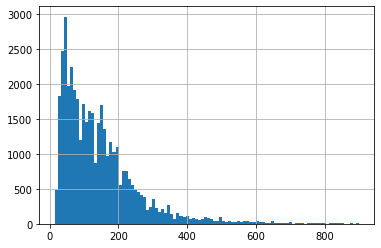

In [ ]:
airbnb_engineered["total_price"].hist(bins=100)

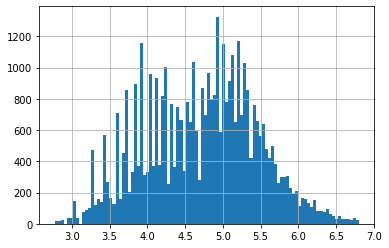

In [ ]:
log_price = np.log1p(airbnb_engineered["total_price"])
log_price.hist(bins=100)

 Transform Reduced Dataset:

In [ ]:
londonAirbnb_reduced['log_price'] = log_price
londonAirbnb_reduced.drop(columns='total_price', inplace=True)

 Transform Engineered Dataset:

In [ ]:
airbnb_engineered['log_price'] = log_price
airbnb_engineered.drop(columns='total_price', inplace=True)

In [ ]:
airbnb_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41855 entries, 1 to 83290
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    41855 non-null  float64
 1   host_is_superhost       41855 non-null  int64  
 2   host_has_profile_pic    41855 non-null  int64  
 3   neighbourhood_cleansed  41855 non-null  int64  
 4   accommodates            41855 non-null  int64  
 5   bathrooms               41855 non-null  float64
 6   bedrooms                41855 non-null  float64
 7   beds                    41855 non-null  float64
 8   guests_included         41855 non-null  int64  
 9   availability_365        41855 non-null  int64  
 10  number_of_reviews       41855 non-null  int64  
 11  reviews_per_month       41855 non-null  float64
 12  reviews_average         41855 non-null  float64
 13  distance_by_group       41855 non-null  int64  
 14  log_price               41855 non-null

In [ ]:
# #### Rename feature names to reflect scaling

# $The\ Models$


## Split train/test
Features(X) / Target(y)

In [ ]:
# split engineered data frame
train_engineered, test_engineered = split(airbnb_engineered, train_size=0.7, random_state=12345)

train_X_engineered = train_engineered.drop(columns='log_price', inplace=False)
train_y_engineered = train_engineered["log_price"]

test_X_engineered = test_engineered.drop(columns='log_price', inplace=False)
test_y_engineered = test_engineered["log_price"]

## Linear Regression

#### Create & Train Model

In [ ]:
LR_model  = LinearRegression()
LR_model.fit(train_X_engineered, train_y_engineered)

print(f"The Linear Regression model intercept is: {LR_model.intercept_}")
print(f"The Linear Regression model coefficients are: {LR_model.coef_}")

The Linear Regression model intercept is: 3.2011231489333047
The Linear Regression model coefficients are: [ 0.00207753  0.03397205  0.07015211  0.02051409  0.20778164  0.02823011
  0.07768076 -0.02255877  0.04133974  0.00027545 -0.00159684 -0.09960275
  0.01408425 -0.08111201]


#### Assess Trained Model

In [ ]:
LR_train_pred_y = LR_model.predict(train_X_engineered)

LR_train_rmse = mse(train_y_engineered, LR_train_pred_y, squared=False)
print(f"RMSE = {LR_train_rmse:.2f}")

RMSE = 0.46


#### Validate Model

In [ ]:
LR_test_pred_y = LR_model.predict(test_X_engineered)

LR_test_rmse = mse(test_y_engineered, LR_test_pred_y, squared=False)
print(f"RMSE = {LR_test_rmse:.2f}")

RMSE = 0.46


#### Visualize Model Validation

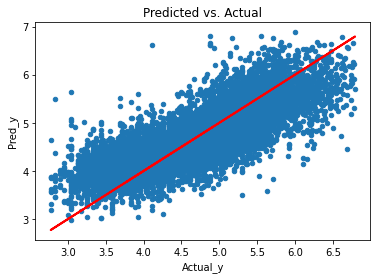

In [ ]:
LR_validate_df = pd.DataFrame({'Actual_y': test_y_engineered, 'Pred_y': LR_test_pred_y})

ax = LR_validate_df.plot.scatter('Actual_y', 'Pred_y', title='Predicted vs. Actual')
ax.plot(test_y_engineered, test_y_engineered, linewidth=2, color='r')

Difference between the true and predicted values, i.e. the prediction errors:

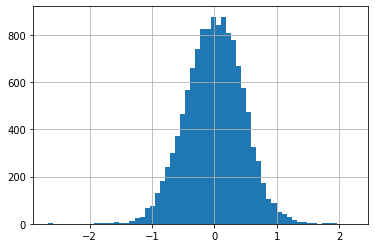

In [ ]:
(LR_validate_df['Actual_y'] - LR_validate_df['Pred_y']).hist(bins=60)

# Decusion Tree

In [ ]:
# split the DF to check validity and prevent biases
X = airbnb_engineered.drop('log_price', axis=1)
y = airbnb_engineered.log_price 

X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state= 35)

In [ ]:
# definr the model and fit it
lbnb_dt = DecisionTreeRegressor()
lbnb_dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
# use the model to predict the other part of the DF
y_train_pred = lbnb_dt.predict(X_train)
y_test_pred = lbnb_dt.predict(X_test)

### Evaluation

In [ ]:
train_rmse = mse(y_train, y_train_pred, squared = True)
test_rmse = mse(y_test, y_test_pred, squared = True)

print(f"RMSE_train = {train_rmse:.2f}")
print(f"RMSE_test = {test_rmse:.2f}")

RMSE_train = 0.00
RMSE_test = 0.31


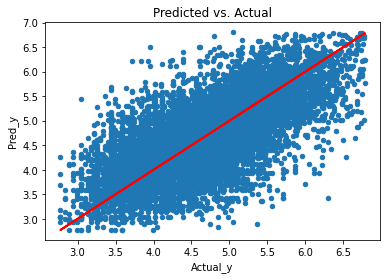

In [ ]:
alidate_dt = pd.DataFrame({'Actual_y': y_test, 'Pred_y': y_test_pred})

ax = alidate_dt.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot(y_test, y_test, linewidth=2, color='r')

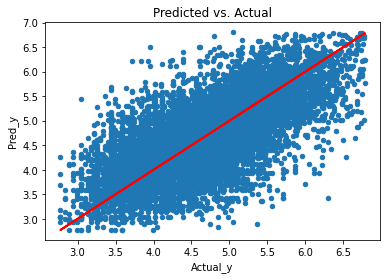

In [ ]:
# construct dataframe validate test DT
validate_df2 = pd.DataFrame({'Actual_y': y_test, 'Pred_y': y_test_pred})

ax = validate_df2.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot( y_test,  y_test, linewidth=2, color='r')

# KNN

In [ ]:
# split reduced data frame
train_engineered,test_engineered = split(airbnb_engineered, train_size=0.7, random_state=1)

train_X_engineered = train_engineered.drop(columns='log_price', inplace=False)
train_y_engineered = train_engineered.log_price

test_X_engineered = test_engineered.drop(columns='log_price', inplace=False)
test_y_engineered = test_engineered.log_price

In [ ]:
KNN_model = KNeighborsRegressor(n_neighbors=12)
KNN_model.fit(train_X_engineered, train_y_engineered)

KNeighborsRegressor(n_neighbors=12)

In [ ]:
# Assess Model (train)
# predict
KNN_train_pred_y = KNN_model.predict(train_X_engineered)
# len(KNN_train_pred_y)  #debug

# assess
KNN_train_rmse = np.sqrt(mse(train_y_engineered, KNN_train_pred_y))
print(f"rmse KNN = {KNN_train_rmse:.2f}")

rmse KNN = 0.50


In [ ]:
# Validate Model (test)
#predict
KNN_test_pred_y = KNN_model.predict(test_X_engineered)
#len(KNN_train_pred_y)  #debug

# validate
KNN_test_rmse = np.sqrt(mse(test_y_engineered, KNN_test_pred_y))
print(f"rmse KNN = {KNN_test_rmse:.2f}")

rmse KNN = 0.55


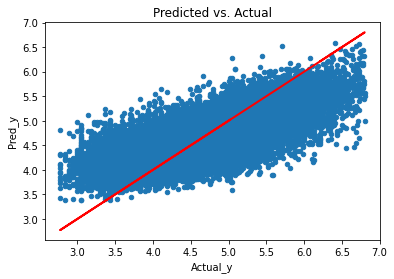

In [ ]:
# construct dataframe
KNN_validate_df = pd.DataFrame({'Actual_y': train_y_engineered, 'Pred_y': KNN_train_pred_y})

ax = KNN_validate_df.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot( train_y_engineered,  train_y_engineered, linewidth=2, color='r')

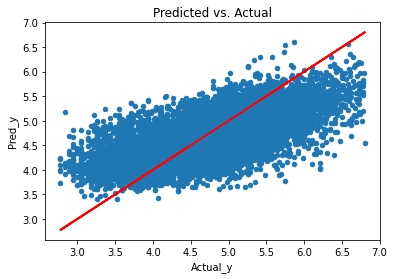

In [ ]:
# construct dataframe validate test KNN
KNN_validate_df = pd.DataFrame({'Actual_y': test_y_engineered, 'Pred_y': KNN_test_pred_y})

ax = KNN_validate_df.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot( test_y_engineered,  test_y_engineered, linewidth=2, color='r')

# $The\ Models\ - Improvement$

## Linear Regression

#### MinMax
For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range.<br>
The range is the difference between the original maximum and original minimum.

In [ ]:
# split reduced data frame
train_imprv, test_imprv = split(airbnb_engineered, train_size=0.7, random_state=12345)
train_engineered1 = train_imprv["log_price"]
test_engineered1 = test_imprv["log_price"]

In [ ]:
# fit - calculate transformation coef 
train_minmax = MinMaxScaler().fit(train_imprv)
test_minmax = MinMaxScaler().fit(test_imprv)

# transform 
train_minmax_transformed = train_minmax.transform(train_imprv)
test_minmax_transformed = test_minmax.transform(test_imprv)

# organize as dataframe
train_minmax_df = pd.DataFrame(train_minmax_transformed, columns=train_imprv.columns, index=train_imprv.index)
test_minmax_df = pd.DataFrame(test_minmax_transformed, columns=test_imprv.columns, index=test_imprv.index)

# get full copy of df
train_imprv_minmax = train_imprv.copy()
test_imprv_minmax = test_imprv.copy()

# update df with scaled values 
for col in train_minmax_df.columns:    
    train_imprv_minmax[col] = train_minmax_df[col]

for col in test_minmax_df.columns:    
    test_imprv_minmax[col] = test_minmax_df[col]

# split to Features(X) and Target(y)
train_X_minmax = train_imprv_minmax.drop(columns='log_price', inplace=False)
train_y_minmax =  train_engineered1

test_X_minmax = test_imprv_minmax.drop(columns='log_price', inplace=False)
test_y_minmax = test_engineered1

In [ ]:
# create & train model
LR_model  = LinearRegression()
LR_model.fit(train_X_minmax, train_y_minmax)
print(f"The LR model intercept is: {LR_model.intercept_}")
print(f"The LR model coefficients are: {LR_model.coef_}")

The LR model intercept is: 3.5244134920034957
The LR model coefficients are: [ 0.11426395  0.03397205  0.07015211  0.65645086  1.87003474  0.22584087
  0.46608457 -0.18047019  0.28937816  0.10053898 -0.23792979 -0.94224197
  0.25754066 -0.89223209]


In [ ]:
# Assess Model
LR_train_pred_y = LR_model.predict(train_X_minmax)
LR_train_rmse = mse(train_y_minmax, LR_train_pred_y, squared=False)
print(f"RMSE = {LR_train_rmse:.2f}")

RMSE = 0.46


In [ ]:
# Validate Model
LR_test_pred_y = LR_model.predict(test_X_minmax)
LR_test_rmse = mse(test_y_minmax, LR_test_pred_y, squared=False)
print(f"RMSE = {LR_test_rmse:.2f}")

RMSE = 0.46


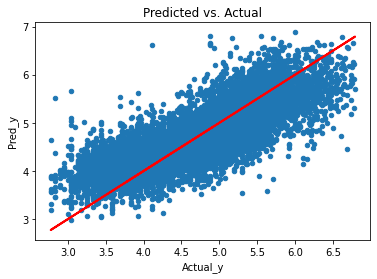

In [ ]:
# Visualize Model Validation
LR_validate_df = pd.DataFrame({'Actual_y': test_y_minmax, 'Pred_y': LR_test_pred_y})

ax = LR_validate_df.plot.scatter('Actual_y', 'Pred_y', title='Predicted vs. Actual')
ax.plot(test_y_minmax, test_y_minmax, linewidth=2, color='r')

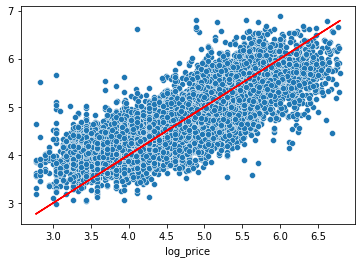

In [ ]:
ax = sns.scatterplot(x=test_y_minmax, y=LR_test_pred_y)
ax.plot(test_y_minmax, test_y_minmax, 'r')

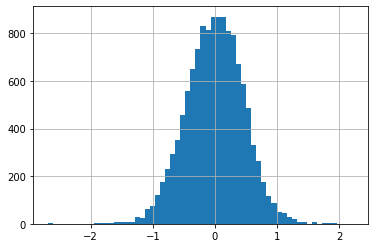

In [ ]:
(LR_validate_df['Actual_y'] - LR_validate_df['Pred_y']).hist(bins=60)

#### MaxAbs
MaxAbsScaler scales each feature by its maximum absolute value.

In [ ]:
# fit
train_maxabs = MaxAbsScaler().fit(train_imprv)
test_maxabs = MaxAbsScaler().fit(test_imprv)

# transform
train_maxabs_transformed = train_maxabs.transform(train_imprv)
test_maxabs_transformed = test_maxabs.transform(test_imprv)

# organize as dataframe
train_maxabs_df  = pd.DataFrame(train_maxabs_transformed, columns=train_imprv.columns, index=train_imprv.index)
test_maxabs_df  = pd.DataFrame(test_maxabs_transformed, columns=test_imprv.columns, index=test_imprv.index)

# get full copy of DF
train_imprv_maxabs = train_imprv.copy()
test_imprv_maxabs = test_imprv.copy()

#update DF with scaled values 
for col in train_maxabs_df.columns:    
    train_imprv_maxabs[col] = train_maxabs_df[col]

for col in test_maxabs_df.columns:    
    test_imprv_maxabs[col] = test_maxabs_df[col]

# split to Features(X) and Target(y) 
train_X_maxabs = train_imprv_maxabs.drop(columns='log_price', inplace=False)
train_y_maxabs = train_engineered1

test_X_maxabs = test_imprv_maxabs.drop(columns='log_price', inplace=False)
test_y_maxabs = test_engineered1

In [ ]:
# create & train model
LR_model  = LinearRegression()
LR_model.fit(train_X_maxabs, train_y_maxabs)
print(f"The LR model intercept is: {LR_model.intercept_}")
print(f"The LR model coefficients are: {LR_model.coef_}")

The LR model intercept is: 3.2011231489332954
The LR model coefficients are: [ 0.20775263  0.03397205  0.07015211  0.65645086  2.07781638  0.22584087
  0.46608457 -0.18047019  0.3307179   0.10053898 -0.23952663 -0.943238
  0.32192582 -0.9733441 ]


In [ ]:
# Assess Model
LR_train_pred_y = LR_model.predict(train_X_maxabs)
LR_train_rmse = mse(train_y_maxabs, LR_train_pred_y, squared=False)
print(f"RMSE = {LR_train_rmse:.2f}")

RMSE = 0.46


In [ ]:
# Validate Model
LR_test_pred_y = LR_model.predict(test_X_maxabs)
LR_test_rmse = mse(test_y_maxabs, LR_test_pred_y, squared=False)
print(f"RMSE = {LR_test_rmse:.2f}")

RMSE = 0.46


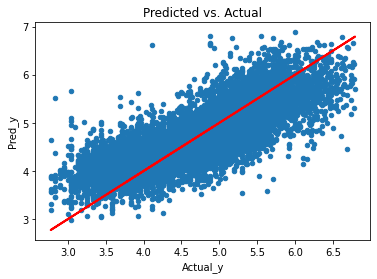

In [ ]:
# Visualize Model Validation
LR_validate_df = pd.DataFrame({'Actual_y': test_y_maxabs, 'Pred_y': LR_test_pred_y})

ax = LR_validate_df.plot.scatter('Actual_y', 'Pred_y', title='Predicted vs. Actual')
ax.plot(test_y_maxabs, test_y_maxabs, linewidth=2, color='r')

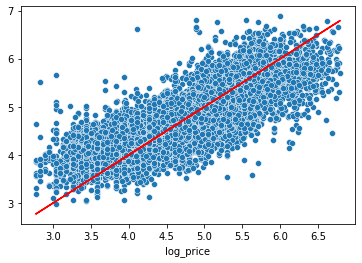

In [ ]:
ax = sns.scatterplot(x=test_y_maxabs, y=LR_test_pred_y)
ax.plot(test_y_maxabs, test_y_maxabs, 'r')

### Feature Engineering - PolynomialFeatures
Engineer new features that expose price interactions and see if they improve model performance.
* Create Interaction features:<br>
    Test how two or more independent variables together impact the target variable.

* Create polynomial features:<br>
    Add polynomial terms to model the nonlinear relationship between an independent variable and the target variable.

**sklearn-pandas**<br>
This module provides a bridge between Scikit-Learn’s machine learning methods and pandas-style Data Frames.<br>
A way to map DataFrame columns to transformations, which are later recombined into features.

In [ ]:
!pip install sklearn-pandas &> /dev/null

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn_pandas import DataFrameMapper

Test different feature combinations for nonlinear effect:

In [ ]:
# configure mapper with all columns passed as lists
mapper = DataFrameMapper([
                          (['distance_by_group'], PolynomialFeatures(2, interaction_only=False, include_bias=False)),
                          (['accommodates'], PolynomialFeatures(2, interaction_only=False, include_bias=False)),
                          (['host_is_superhost'], PolynomialFeatures(2, interaction_only=False, include_bias=False))
                          ])

Generate interaction features for train_X:

In [ ]:
# fit_transform interaction features - train
poly_features_train = mapper.fit_transform(train_X_maxabs)
poly_train_df = pd.DataFrame(poly_features_train)
print(poly_train_df.shape)
print(train_X_maxabs.shape)

(29298, 6)
(29298, 14)


In [ ]:
poly_train_df.head()

,0,1,2,3,4,5
0,0.250000,0.062500,0.2,0.04,0.0,0.0
1,0.166667,0.027778,0.6,0.36,1.0,1.0
2,0.083333,0.006944,0.3,0.09,0.0,0.0
3,0.166667,0.027778,0.2,0.04,0.0,0.0
4,0.583333,0.340278,0.1,0.01,0.0,0.0


In [ ]:
# set index same as train_X_maxabs
poly_train_df.set_index(train_X_maxabs.index, inplace=True)
poly_train_df.head()

,0,1,2,3,4,5
78069,0.250000,0.062500,0.2,0.04,0.0,0.0
2778,0.166667,0.027778,0.6,0.36,1.0,1.0
36487,0.083333,0.006944,0.3,0.09,0.0,0.0
11098,0.166667,0.027778,0.2,0.04,0.0,0.0
7282,0.583333,0.340278,0.1,0.01,0.0,0.0


In [ ]:
train_X_maxabs.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group
78069,0.98,0.0,1.0,0.87500,0.2,0.1250,0.166667,0.125,0.125,0.000000,0.013333,0.059134,0.8000,0.250000
2778,0.79,1.0,1.0,0.62500,0.6,0.4375,0.500000,0.250,0.375,0.000000,0.026667,0.005280,0.9625,0.166667
36487,0.99,0.0,1.0,1.00000,0.3,0.1250,0.166667,0.250,0.125,0.032877,0.460000,0.256600,0.8750,0.083333
11098,0.86,0.0,1.0,0.71875,0.2,0.1250,0.166667,0.125,0.125,0.000000,0.040000,0.029567,1.0000,0.166667
7282,1.00,0.0,1.0,0.18750,0.1,0.1250,0.166667,0.125,0.125,0.457534,0.033333,0.023231,1.0000,0.583333


In [ ]:
# merge poly_df with train df
train_X_maxabs = pd.merge(poly_train_df, train_X_maxabs, how='inner', left_index=True, right_index=True)
print(train_X_maxabs.shape)
train_X_maxabs.head()

(29298, 20)


,0,1,2,3,4,5,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group
78069,0.250000,0.062500,0.2,0.04,0.0,0.0,0.98,0.0,1.0,0.87500,0.2,0.1250,0.166667,0.125,0.125,0.000000,0.013333,0.059134,0.8000,0.250000
2778,0.166667,0.027778,0.6,0.36,1.0,1.0,0.79,1.0,1.0,0.62500,0.6,0.4375,0.500000,0.250,0.375,0.000000,0.026667,0.005280,0.9625,0.166667
36487,0.083333,0.006944,0.3,0.09,0.0,0.0,0.99,0.0,1.0,1.00000,0.3,0.1250,0.166667,0.250,0.125,0.032877,0.460000,0.256600,0.8750,0.083333
11098,0.166667,0.027778,0.2,0.04,0.0,0.0,0.86,0.0,1.0,0.71875,0.2,0.1250,0.166667,0.125,0.125,0.000000,0.040000,0.029567,1.0000,0.166667
7282,0.583333,0.340278,0.1,0.01,0.0,0.0,1.00,0.0,1.0,0.18750,0.1,0.1250,0.166667,0.125,0.125,0.457534,0.033333,0.023231,1.0000,0.583333


Generate interaction features for test_X:

In [ ]:
# fit_transform interaction features - test
poly_features_test = mapper.fit_transform(test_X_maxabs)
poly_test_df = pd.DataFrame(poly_features_test)
print(poly_test_df.shape)
print(test_X_maxabs.shape)

(12557, 6)
(12557, 14)


In [ ]:
poly_test_df.head()

,0,1,2,3,4,5
0,0.500000,0.250000,0.2,0.04,1.0,1.0
1,0.250000,0.062500,0.5,0.25,1.0,1.0
2,0.500000,0.250000,0.4,0.16,0.0,0.0
3,0.583333,0.340278,0.1,0.01,1.0,1.0
4,0.083333,0.006944,0.4,0.16,0.0,0.0


In [ ]:
# set index same as test_X_maxabs
poly_test_df.set_index(test_X_maxabs.index, inplace=True)
poly_test_df.head()

,0,1,2,3,4,5
11745,0.500000,0.250000,0.2,0.04,1.0,1.0
44598,0.250000,0.062500,0.5,0.25,1.0,1.0
27643,0.500000,0.250000,0.4,0.16,0.0,0.0
68797,0.583333,0.340278,0.1,0.01,1.0,1.0
62159,0.083333,0.006944,0.4,0.16,0.0,0.0


In [ ]:
test_X_maxabs.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group
11745,1.00,1.0,1.0,0.40625,0.2,0.1875,0.166667,0.000,0.125,0.791781,0.760000,0.207739,0.99375,0.500000
44598,0.67,1.0,1.0,0.81250,0.5,0.3750,0.500000,0.375,0.500,0.052055,0.080000,0.062118,0.94375,0.250000
27643,1.00,0.0,1.0,0.75000,0.4,0.1250,0.333333,0.375,0.500,0.000000,0.026667,0.011202,0.98750,0.500000
68797,1.00,1.0,1.0,0.34375,0.1,0.1875,0.166667,0.125,0.125,0.000000,0.020000,0.036660,1.00000,0.583333
62159,0.99,0.0,1.0,0.81250,0.4,0.1250,0.166667,0.250,0.250,0.000000,0.206667,0.276986,0.93750,0.083333


In [ ]:
# merge poly_df with test df
test_X_maxabs = pd.merge(poly_test_df, test_X_maxabs, how='inner', left_index=True, right_index=True)
print(test_X_maxabs.shape)
test_X_maxabs.head()

(12557, 20)


,0,1,2,3,4,5,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group
11745,0.500000,0.250000,0.2,0.04,1.0,1.0,1.00,1.0,1.0,0.40625,0.2,0.1875,0.166667,0.000,0.125,0.791781,0.760000,0.207739,0.99375,0.500000
44598,0.250000,0.062500,0.5,0.25,1.0,1.0,0.67,1.0,1.0,0.81250,0.5,0.3750,0.500000,0.375,0.500,0.052055,0.080000,0.062118,0.94375,0.250000
27643,0.500000,0.250000,0.4,0.16,0.0,0.0,1.00,0.0,1.0,0.75000,0.4,0.1250,0.333333,0.375,0.500,0.000000,0.026667,0.011202,0.98750,0.500000
68797,0.583333,0.340278,0.1,0.01,1.0,1.0,1.00,1.0,1.0,0.34375,0.1,0.1875,0.166667,0.125,0.125,0.000000,0.020000,0.036660,1.00000,0.583333
62159,0.083333,0.006944,0.4,0.16,0.0,0.0,0.99,0.0,1.0,0.81250,0.4,0.1250,0.166667,0.250,0.250,0.000000,0.206667,0.276986,0.93750,0.083333


### Check improvement:

In [ ]:
# create & train model
LR_model  = LinearRegression()
LR_model.fit(train_X_maxabs, train_y_maxabs)
print(f"The LR model intercept is: {LR_model.intercept_}")
print(f"The LR model coefficients are: {LR_model.coef_}")

The LR model intercept is: 2.9757170905884527
The LR model coefficients are: [ 2.23522069e+12  1.93920898e+00 -8.76504557e+10 -3.22579129e+00
  2.87143702e+11 -1.32953536e+11  1.85769138e-01 -1.54190165e+11
  6.46764332e-02  5.71732175e-01  8.76504557e+10  4.91060895e-01
  7.34638280e-01 -7.93731181e-02  3.34766378e-01  1.02803270e-01
 -2.08089485e-01 -9.77809906e-01  3.45294952e-01 -2.23522069e+12]


In [ ]:
# Assess Model
LR_train_pred_y = LR_model.predict(train_X_maxabs)
LR_train_rmse = mse(train_y_maxabs, LR_train_pred_y, squared=False)
print(f"RMSE = {LR_train_rmse:.2f}")

RMSE = 0.44


In [ ]:
# Validate Model
LR_test_pred_y = LR_model.predict(test_X_maxabs)
LR_test_rmse = mse(test_y_maxabs, LR_test_pred_y, squared=False)
print(f"RMSE = {LR_test_rmse:.2f}")

RMSE = 0.44


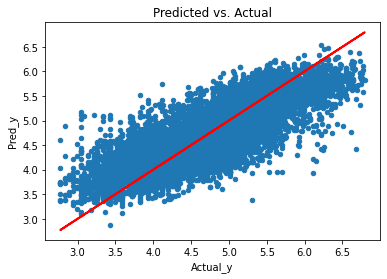

In [ ]:
# Visualize Model Validation
LR_validate_df = pd.DataFrame({'Actual_y': test_y_maxabs, 'Pred_y': LR_test_pred_y})

ax = LR_validate_df.plot.scatter('Actual_y', 'Pred_y', title='Predicted vs. Actual')
ax.plot(test_y_maxabs, test_y_maxabs, linewidth=2, color='r')

## DecisionTree

In [ ]:
airbnb_Analysis = airbnb_engineered[(airbnb_engineered.log_price>6.5) & (airbnb_engineered.log_price <7)]
airbnb_Analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1609 to 81402
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    260 non-null    float64
 1   host_is_superhost       260 non-null    int64  
 2   host_has_profile_pic    260 non-null    int64  
 3   neighbourhood_cleansed  260 non-null    int64  
 4   accommodates            260 non-null    int64  
 5   bathrooms               260 non-null    float64
 6   bedrooms                260 non-null    float64
 7   beds                    260 non-null    float64
 8   guests_included         260 non-null    int64  
 9   availability_365        260 non-null    int64  
 10  number_of_reviews       260 non-null    int64  
 11  reviews_per_month       260 non-null    float64
 12  reviews_average         260 non-null    float64
 13  distance_by_group       260 non-null    int64  
 14  log_price               260 non-null 

#### RobustScaler
RobustScaler transforms the feature vector by subtracting the median and then dividing by the interquartile range (75% value — 25% value).

In [ ]:
airbnb_engineered.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group,log_price
1,89.0,0,1,23,2,1.0,1.0,0.0,1,347,21,0.18,22.142857,3,4.394449
2,83.0,0,1,31,2,1.0,1.0,1.0,2,288,89,0.70,22.142857,2,5.017280
3,96.0,0,1,32,6,2.0,3.0,3.0,3,326,42,0.37,21.428571,1,5.968708
5,100.0,1,1,17,2,1.5,1.0,0.0,1,348,129,1.04,22.142857,4,3.401197
6,88.0,0,1,22,2,1.0,1.0,1.0,1,348,6,0.05,21.000000,6,4.615121


In [ ]:
scaler = RobustScaler()
airbnb_engineered_rscaled = scaler.fit_transform(airbnb_engineered)
airbnb_engineered_rscaled = pd.DataFrame(airbnb_engineered_rscaled, columns= airbnb_engineered.columns)
airbnb_engineered_rscaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41855 entries, 0 to 41854
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    41855 non-null  float64
 1   host_is_superhost       41855 non-null  float64
 2   host_has_profile_pic    41855 non-null  float64
 3   neighbourhood_cleansed  41855 non-null  float64
 4   accommodates            41855 non-null  float64
 5   bathrooms               41855 non-null  float64
 6   bedrooms                41855 non-null  float64
 7   beds                    41855 non-null  float64
 8   guests_included         41855 non-null  float64
 9   availability_365        41855 non-null  float64
 10  number_of_reviews       41855 non-null  float64
 11  reviews_per_month       41855 non-null  float64
 12  reviews_average         41855 non-null  float64
 13  distance_by_group       41855 non-null  float64
 14  log_price               41855 non-null

#### *StandardScaler*
Normalize/standardize (i.e. μ = 0 and σ = 1) the features of the training set individually, before applying the model.<br>
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance, i.e. dividing all the values by the standard deviation.

In [ ]:
scaler = StandardScaler() 
airbnb_engineered_sscaled = scaler.fit_transform(airbnb_engineered)
airbnb_engineered_sscaled = pd.DataFrame(airbnb_engineered_sscaled, columns= airbnb_engineered.columns)
airbnb_engineered_sscaled.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group,log_price
0,-0.039157,-0.579346,0.053845,0.102256,-0.678436,-0.545477,-0.455042,-1.537818,-0.548161,1.577698,-0.047551,-0.816203,0.394401,-0.14267,-0.433692
1,-0.457690,-0.579346,0.053845,1.104722,-0.678436,-0.545477,-0.455042,-0.656257,0.230105,1.138618,2.405149,-0.247821,0.394401,-0.69339,0.404521
2,0.449132,-0.579346,0.053845,1.230030,1.489400,1.312585,1.953986,1.106863,1.008370,1.421415,0.709900,-0.608525,0.045924,-1.24411,1.684964
3,0.728154,1.726085,0.053845,-0.649594,-0.678436,0.383554,-0.455042,-1.537818,-0.548161,1.585140,3.847913,0.123812,0.394401,0.40805,-1.770423
4,-0.108912,-0.579346,0.053845,-0.023053,-0.678436,-0.545477,-0.455042,-0.656257,-0.548161,1.585140,-0.588588,-0.958298,-0.163163,1.50949,-0.136710


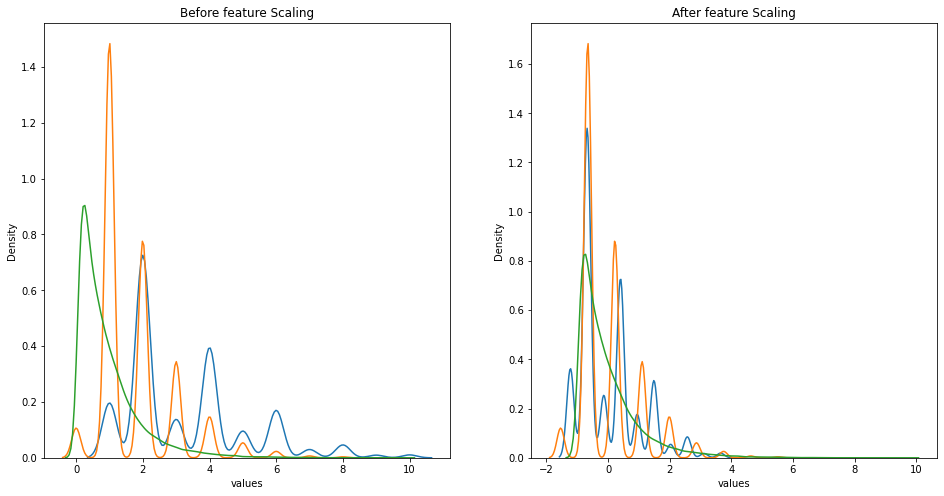

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
ax1.set_title('Before feature Scaling')
sns.kdeplot(airbnb_engineered['accommodates'], ax=ax1)
sns.kdeplot(airbnb_engineered['beds'], ax=ax1)
sns.kdeplot(airbnb_engineered['reviews_per_month'], ax=ax1)
ax2.set_title('After feature Scaling')
sns.kdeplot(airbnb_engineered_sscaled['accommodates'], ax=ax2)
sns.kdeplot(airbnb_engineered_sscaled['beds'], ax=ax2)
sns.kdeplot(airbnb_engineered_sscaled['reviews_per_month'], ax=ax2)
ax1.xaxis.set_label_text('values')
ax2.xaxis.set_label_text('values')
plt.show()

## DecisionTree

In [ ]:
airbnb_engineered_dt = airbnb_engineered_rscaled.copy()
airbnb_engineered_dt.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group,log_price
0,-0.5000,0.0,0.0,0.000000,0.0,0.0,0.0,-1.0,0.0,0.978571,0.36,-0.494737,0.083333,0.0,-0.351622
1,-0.8750,0.0,0.0,0.727273,0.0,0.0,0.0,0.0,1.0,0.767857,3.08,0.052632,0.083333,-0.5,0.194051
2,-0.0625,0.0,0.0,0.818182,2.0,2.0,2.0,2.0,2.0,0.903571,1.20,-0.294737,-0.333333,-1.0,1.027613
3,0.1875,1.0,0.0,-0.545455,0.0,1.0,0.0,-1.0,0.0,0.982143,4.68,0.410526,0.083333,0.5,-1.221827
4,-0.5625,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0,0.982143,-0.24,-0.631579,-0.583333,1.5,-0.158288


In [ ]:
airbnb_engineered_dt = airbnb_engineered_rscaled.copy()
airbnb_engineered_dt.drop(['host_acceptance_rate','host_is_superhost',
                           'host_has_profile_pic','number_of_reviews',
                           'reviews_average'
                           ], axis=1,inplace= True)
airbnb_engineered_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41855 entries, 0 to 41854
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  41855 non-null  float64
 1   accommodates            41855 non-null  float64
 2   bathrooms               41855 non-null  float64
 3   bedrooms                41855 non-null  float64
 4   beds                    41855 non-null  float64
 5   guests_included         41855 non-null  float64
 6   availability_365        41855 non-null  float64
 7   reviews_per_month       41855 non-null  float64
 8   distance_by_group       41855 non-null  float64
 9   log_price               41855 non-null  float64
dtypes: float64(10)
memory usage: 3.2 MB


In [ ]:
airbnb_engineered_dt.head()

,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,reviews_per_month,distance_by_group,log_price
0,0.000000,0.0,0.0,0.0,-1.0,0.0,0.978571,-0.494737,0.0,-0.351622
1,0.727273,0.0,0.0,0.0,0.0,1.0,0.767857,0.052632,-0.5,0.194051
2,0.818182,2.0,2.0,2.0,2.0,2.0,0.903571,-0.294737,-1.0,1.027613
3,-0.545455,0.0,1.0,0.0,-1.0,0.0,0.982143,0.410526,0.5,-1.221827
4,-0.090909,0.0,0.0,0.0,0.0,0.0,0.982143,-0.631579,1.5,-0.158288


In [ ]:
X = airbnb_engineered_dt.drop('log_price', axis=1)
y = airbnb_engineered.log_price 

X_train, X_test, y_train, y_test = split(X, y, train_size=0.7, random_state= 35)

In [ ]:
DT_MAX_DEPTH = 7
DT_MIN_SAMPLES_LEAF = 4
DT_MIN_SAMPLES_SPLIT= 3
DT_MAX_LEAF_NODES = 100

In [ ]:
#lbnb_dt = DecisionTreeRegressor()
lbnb_dt = DecisionTreeRegressor(max_depth=DT_MAX_DEPTH, min_samples_leaf=DT_MIN_SAMPLES_LEAF, min_samples_split=DT_MIN_SAMPLES_SPLIT, max_leaf_nodes=DT_MAX_LEAF_NODES)
lbnb_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=100, min_samples_leaf=4,
                      min_samples_split=3)

In [ ]:
y_train_pred = lbnb_dt.predict(X_train)
y_test_pred = lbnb_dt.predict(X_test)

### Plot Decision Tree with dtreeviz Package

In [ ]:
DT_MAX_DEPTH = 4
DT_MIN_SAMPLES_LEAF = 4
DT_MIN_SAMPLES_SPLIT= 3
DT_MAX_LEAF_NODES = 100
lbnb = DecisionTreeRegressor(max_depth=DT_MAX_DEPTH, min_samples_leaf=DT_MIN_SAMPLES_LEAF, min_samples_split=DT_MIN_SAMPLES_SPLIT, max_leaf_nodes=DT_MAX_LEAF_NODES)
lbnb.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=100, min_samples_leaf=4,
                      min_samples_split=3)

In [ ]:
from IPython.display import HTML
viz = dtreeviz(lbnb,
               X_train,
               y_train,
               target_name="price",
               feature_names=X_train.columns,
               title = "Londonairbnb set regression")
               #orientation='LR',
               #fontname="Arial")

viz
viz.save_svg()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


'/tmp/DTreeViz_73.svg'

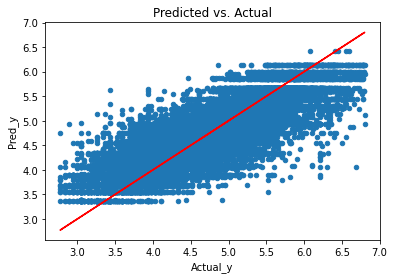

In [ ]:
dt_validate_df = pd.DataFrame({'Actual_y': y_train, 'Pred_y': y_train_pred})
ax = dt_validate_df.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot(y_train, y_train , 'r')

In [ ]:
train_rmse = mse(y_train, y_train_pred, squared = True)
test_rmse = mse(y_test, y_test_pred, squared = True)

print(f"RMSE_train = {train_rmse:.2f}")
print(f"RMSE_test = {test_rmse:.2f}")

RMSE_train = 0.18
RMSE_test = 0.19


### Features importances

neighbourhood_cleansed: 0.08261943430825411
accommodates   : 0.6395755921505042
bathrooms      : 0.062406416927670835
bedrooms       : 0.0351812950837914
beds           : 0.0007076442313770301
guests_included: 0.02664212229024746
availability_365: 0.003952119781588984
reviews_per_month: 0.026123656778014943
distance_by_group: 0.12279171844855113


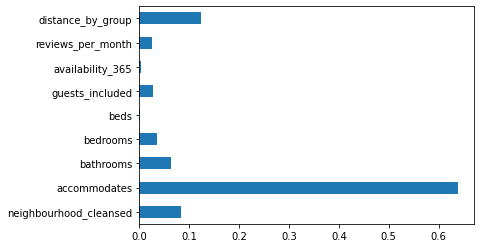

In [ ]:
for feature, importance in zip(X.columns, lbnb_dt.feature_importances_):
    print(f'{feature:15}: {importance}')

pd.Series(lbnb_dt.feature_importances_, index=X.columns).plot.barh()


## KNN

Improving KNN with MinMaxScaler

In [ ]:
airbnb_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41855 entries, 1 to 83290
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_acceptance_rate    41855 non-null  float64
 1   host_is_superhost       41855 non-null  int64  
 2   host_has_profile_pic    41855 non-null  int64  
 3   neighbourhood_cleansed  41855 non-null  int64  
 4   accommodates            41855 non-null  int64  
 5   bathrooms               41855 non-null  float64
 6   bedrooms                41855 non-null  float64
 7   beds                    41855 non-null  float64
 8   guests_included         41855 non-null  int64  
 9   availability_365        41855 non-null  int64  
 10  number_of_reviews       41855 non-null  int64  
 11  reviews_per_month       41855 non-null  float64
 12  reviews_average         41855 non-null  float64
 13  distance_by_group       41855 non-null  int64  
 14  log_price               41855 non-null

In [ ]:
airbnb_engineered.head()

,host_acceptance_rate,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,availability_365,number_of_reviews,reviews_per_month,reviews_average,distance_by_group,log_price
1,89.0,0,1,23,2,1.0,1.0,0.0,1,347,21,0.18,22.142857,3,4.394449
2,83.0,0,1,31,2,1.0,1.0,1.0,2,288,89,0.70,22.142857,2,5.017280
3,96.0,0,1,32,6,2.0,3.0,3.0,3,326,42,0.37,21.428571,1,5.968708
5,100.0,1,1,17,2,1.5,1.0,0.0,1,348,129,1.04,22.142857,4,3.401197
6,88.0,0,1,22,2,1.0,1.0,1.0,1,348,6,0.05,21.000000,6,4.615121


In [ ]:
# split reduced data frame
airbnb_engineered_new_knn = airbnb_engineered.copy()
train_imprv, test_imprv = split(airbnb_engineered_new_knn, train_size=0.7, random_state=1)
train_engineered1 =train_imprv.log_price
test_engineered1 =test_imprv.log_price

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# calculate transformation coef 
train_imprv_minmax_scale_ = MinMaxScaler().fit(train_imprv)
# print(f'train data minmax scale: {train_imprv_minmax_scale_.scale_}')
test_imprv_minmax_scale_ = MinMaxScaler().fit(test_imprv)
# print(f'test data minmax  scale: {test_imprv_minmax_scale_.scale_}')

# transform selected columns
train_minmax_np_scaled = train_imprv_minmax_scale_.transform(train_imprv)
test_minmax_np_scaled = train_imprv_minmax_scale_.transform(test_imprv)

# organize as dataframe
train_minmax_scaled  = pd.DataFrame(train_minmax_np_scaled, columns=train_imprv.columns, index=train_imprv.index)
test_minmax_scaled  = pd.DataFrame(test_minmax_np_scaled, columns=test_imprv.columns, index=test_imprv.index)

# get full copy of DF
train_imprv_minmax = train_imprv.copy()
test_imprv_minmax = test_imprv.copy()

#update DF with scaled values 
for col in train_minmax_scaled.columns:    
    train_imprv_minmax[col] = train_minmax_scaled[col]

for col in test_minmax_scaled.columns:    
    test_imprv_minmax[col] = test_minmax_scaled[col]

# split to  Features(X) and Target(y) for both train and test data
train_X_minmax = train_imprv_minmax.drop(columns='log_price', inplace=False)
train_y_minmax =train_engineered1

test_X_minmax = test_imprv_minmax.drop(columns='log_price', inplace=False)
test_y_minmax = test_engineered1

In [ ]:
train_X_minmax.shape

(29298, 14)

In [ ]:
KNN_model = KNeighborsRegressor(n_neighbors=12 ,metric="manhattan" )
KNN_model.fit(train_X_minmax, train_y_minmax)

KNeighborsRegressor(metric='manhattan', n_neighbors=12)

In [ ]:
# Assess Model (train)
# predict
KNN_train_pred_y = KNN_model.predict(train_X_minmax)


# assess
KNN_train_rmse = np.sqrt(mse(train_y_minmax, KNN_train_pred_y))
print(f"rmse KNN Improve = {KNN_train_rmse:.2f}")

rmse KNN Improve = 0.38


In [ ]:
# Validate Model (test)
#predict
KNN_test_pred_y = KNN_model.predict(test_X_minmax)
#len(KNN_train_pred_y)  #debug

# validate
KNN_test_rmse = np.sqrt(mse(test_y_minmax, KNN_test_pred_y))
print(f"rmse KNN Improve = {KNN_test_rmse:.2f}")

rmse KNN Improve = 0.41


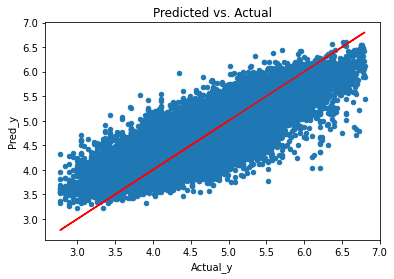

In [ ]:
# construct dataframe train
KNN_validate_df = pd.DataFrame({'Actual_y': train_y_minmax, 'Pred_y': KNN_train_pred_y})

ax = KNN_validate_df.plot('Actual_y', 'Pred_y', kind='scatter',   title='Predicted vs. Actual')
ax.plot(train_y_minmax,train_y_minmax, 'r')

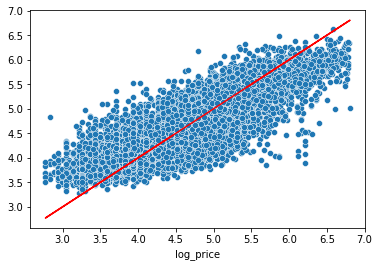

In [ ]:
#  test validate
ax = sns.scatterplot(x=test_y_minmax, y=KNN_test_pred_y)
ax.plot(test_y_minmax,test_y_minmax, 'r')